# 真伪语音鉴别算法评测 - 孙夏恩

### 基于特征级联与BinaryFocalLoss卷积神经网络语音真伪鉴别算法实验

<img src="./pipeline.png" alt="pipeline" width="500" height="313" align="left" />

# Train

## 输入加载部分

In [1]:
DATASET_TYPE = "train"
path_prefix = "./{}/flac/".format(DATASET_TYPE)
path_postfix = ".flac"
trainList = []
trainLabelList = []
#读入train.txt语音路径和标签
with open("./{}.txt".format(DATASET_TYPE),"r") as f:
    for line in f.readlines():
        name, label = line.strip("\n").split(" ")
        trainList.append(path_prefix+name+path_postfix)
        trainLabelList.append(label)

#实验过程中，dev部分的bonafide数据补充
dip=0
with open("./dev.txt","r") as f_dip:   
    for line_dip in f_dip.readlines():
        name, label = line_dip.strip("\n").split(" ")
        if label == "bonafide":
            dip+=1
            trainList.append("./dev/flac/"+name+path_postfix)
            trainLabelList.append(label)

## 语音数据分布

<img src="./dist.png" alt="Dist" width="500" height="313" align="left" />

## 新建Config类，调整实验配置的参数可以都在统一此处修改

In [2]:
class Config(object):
    def __init__(self,sampling_rate=16000, duration=600,
                 use_mfcc=True, n_folds=1, learning_rate=0.01, 
                 max_epochs=500, n_mfcc=14,n_gfcc=16, use_smote=False, use_trim=True, piece_frame_size=58):
        self.sampling_rate = sampling_rate #采样率
        self.use_smote = use_smote #是否使用smote
        self.use_trim = use_trim   #是否使用librosa的trim功能
        self.duration = duration   #语音片段的长度 单位second
        self.use_mfcc = use_mfcc   #是否使用mfcc
        self.n_mfcc = n_mfcc       #配置mfcc系数个数
        self.n_gfcc = n_gfcc       #配置gfcc系数个数
        self.n_folds = n_folds     #使用kfold方法求平均验证各个实验结果
        self.learning_rate = learning_rate   #配置学习率
        self.max_epochs = max_epochs  #配置最大迭代轮次
        self.piece_frame_size = piece_frame_size  #配置切割后的特征片段长度
config = Config()

## librosa采样获取1D-array

In [4]:
import librosa
from spafe.utils import vis
from spafe.features.mfcc import mfcc, imfcc
from spafe.features.gfcc import gfcc
import numpy as np
def getFeat(sound_path,adjusted_duration):
    '''
        输入：sound_path：语音的路径
              adjusted_duration：需要的秒数
        返回值： X,y   //X,y in list style
    '''
    # 读入列表中的语音
    if config.use_trim: #去除静寂部分
        sig = librosa.effects.trim(librosa.audio.load(sound_path,sr = config.sampling_rate)[0],top_db=50)[0]
    else:
        sig = librosa.audio.load(sound_path,sr = config.sampling_rate)[0]
    ori_frame_len = sig.shape[0]
    expected_frame_len = adjusted_duration*(config.sampling_rate//1000) #根据最小分片长度需要的秒数计算最小长度
    #长度不够可以padding
    if ori_frame_len < expected_frame_len:
        max_offset = expected_frame_len - ori_frame_len
        offset = np.random.randint(max_offset)
        sig = np.pad(sig, (offset, max_offset - offset), "constant")
    return sig

## 获取训练集原始特征集合 

In [5]:
def getRawXy(mList,mLabelList):
    '''
        输入： mList(@NotNullable), mLabelList(@Nullable)
        返回值： X,y   //X,y 为list类型
    '''
    X = []
    for i, sound_file in enumerate(mList):
        frames = getFeat(sound_file,config.duration)
        # 不等长语音同时添加到列表，生成Raw X
        X.append(frames)
    # 标签映射
    def mapFun(x):
        if x=="bonafide":
            return 1
        else:
            return 0
    if len(mLabelList)==0:
        y = []
    else:
        y = list(map(mapFun,mLabelList))
    return X,y

X,y = getRawXy(trainList,trainLabelList) #train

## 计算MFCC、GFCC特征 

In [7]:
def getMfccs(sig):
     #  初始化一些常规参数
    num_ceps = config.n_mfcc
    low_freq = 0
    high_freq = 2000
    nfft = 512
    dct_type = 2
    use_energy = True #C0系数将被重写，以对数形式呈现
    nfilts=24
    lifter = 5
    normalize = False
    # 计算特征
    mfccs = mfcc(sig = sig,
                 fs = config.sampling_rate,
                 num_ceps=num_ceps,
                 nfft=nfft,
                 nfilts=24,
                 low_freq=low_freq,
                 high_freq=high_freq,
                 dct_type=dct_type,
                 use_energy=use_energy,
                 lifter=lifter,
                 normalize=normalize)
    # 转置一次之后num_ceps将到第二维度记录
    mfccs = mfccs.transpose() 
    #添加一个维度适应卷积网络的输入
    mfccs = mfccs[:,:,np.newaxis] 
    # 返回值的numpy.shape形如 (num_ceps, frameindex, 1)
    return mfccs

In [8]:
def getGfccs(sig):
    gfccs = gfcc(sig = sig,
                 fs = config.sampling_rate,
                 num_ceps=config.n_gfcc)
    #所有操作与Mfcc对齐，便于后续融合
    gfccs = gfccs.transpose()
    gfccs = gfccs[:,:,np.newaxis]
    return gfccs

## 生成检测单元

In [10]:
#检查config配置情况，添加断言
print("0.6s对应的58帧片段：",getMfccs(np.empty(config.sampling_rate*config.duration//1000)).shape)
assert getMfccs(np.empty(config.sampling_rate*config.duration//1000)).shape[1] == config.piece_frame_size

0.6s对应的58帧片段： (14, 58, 1)


In [11]:
def generatePieces(frames,frames_label):
    '''
        输入:    frames(3D numpy.array)
                 frames_label(int)
        返回值： frames_list(4D numpy.array)  present features in a stick period
                 frames_labels(1D numpy.array)
    '''
    frames_list = np.array([])
    frames_labels = []
    cursor = 0
    if frames.shape[1] >= config.piece_frame_size: #config.piece_frame_size的设置参考分帧长和帧移确定，也可通过getMfccs测得
        while cursor + config.piece_frame_size <= frames.shape[1]: #遍历，基于config.piece_frame_size切割 
            if frames_list.shape[0] == 0:
                frames_list = np.array(frames[np.newaxis,:,:config.piece_frame_size,:])
            else:
                frames_list = np.concatenate((frames_list,frames[np.newaxis,:,cursor:cursor+config.piece_frame_size,:]))
            frames_labels.append(frames_label)
            cursor += config.piece_frame_size
    else:
        print("ERR: should adjust in getFeat !")
    return frames_list,np.array(frames_labels)

## 生成特征并特征融合 

In [12]:
X_train = np.array([])
y_train = np.array([])
for i, sig in enumerate(X):
    mfccs = getMfccs(sig)
    gfccs = getGfccs(sig)
    mixed_fccs = np.concatenate((mfccs,gfccs)) #由于前面步骤的转置，现在融合可以直接在第一维度堆叠
    frames_lists,frames_labels = generatePieces(mixed_fccs,y[i])
    if X_train.shape[0] == 0:
        X_train = frames_lists
        y_train = frames_labels
    else:
        X_train = np.vstack((X_train,frames_lists))  #形成numpy.shape统一的训练样本，堆叠
        y_train = np.hstack((y_train,frames_labels)) 

In [13]:
X_train.shape

(10901, 30, 58, 1)

## SMOTE实验 

In [14]:
#作Smote过采样尝试调整比例
from imblearn.over_sampling import SMOTE
smoteOpt = SMOTE(sampling_strategy={1:4000},random_state=42)
if config.use_smote:
    X_train,y_train = smoteOpt.fit_resample(X_train,y_train)

## 对特征进行数据的标准化处理

In [15]:
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)
X_train = (X_train - mean)/std

## 搭建卷积神经网络 

In [16]:
from tensorflow.keras.layers import (Conv2D,  BatchNormalization, Flatten, MaxPool2D, concatenate, Activation,Dropout,Dense)
from tensorflow.keras.utils import Sequence
from tensorflow.keras import backend as K
from tensorflow.keras import losses, models, optimizers,regularizers
from keras.callbacks import EarlyStopping,ModelCheckpoint,ReduceLROnPlateau
model = models.Sequential()
model.add(Conv2D(32,(4,4),activation='relu',strides=(1,1),input_shape=(config.n_gfcc+config.n_mfcc,config.piece_frame_size,1)))
model.add(Conv2D(32,(4,4),activation='relu',strides=(1,1)))
model.add(MaxPool2D()) #最大池化采用poolsize = 2*2，不带stride
model.add(Dropout(0.5))
model.add(Conv2D(64,(4,4),activation='relu')) #加深filter
model.add(Conv2D(64,(4,4),activation='relu'))
model.add(MaxPool2D())
model.add(Dropout(0.5))
model.add(Flatten()) #展开成一维形式
model.add(Dense(300,kernel_initializer='random_uniform',
                bias_initializer='zeros',activation='relu',kernel_regularizer=regularizers.l2(0.0001)))
model.add(Dense(1))
model.add(Activation("sigmoid"))

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 27, 55, 32)        544       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 52, 32)        16416     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 26, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 12, 26, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 9, 23, 64)         32832     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 6, 20, 64)         65600     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 3, 10, 64)         0

## focal loss应用于二分类

In [18]:
import tensorflow as tf
import tensorflow.keras.backend as K
def binary_focal_loss(gamma=2, alpha=0.25):
    """
    基本公式：
    focal_loss(p_t) = -alpha_t * (1 - p_t)**gamma * log(p_t)
        where p = sigmoid(x), p_t = p or 1 - p depending on if the label is 1 or 0, respectively.
    文献基础:
        https://arxiv.org/pdf/1708.02002.pdf
    """
    alpha = tf.constant(alpha, dtype=tf.float32)
    gamma = tf.constant(gamma, dtype=tf.float32)

    def binary_focal_loss_fixed(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        alpha_t = y_true*alpha + (K.ones_like(y_true)-y_true)*(1-alpha)
    
        p_t = y_true*y_pred + (K.ones_like(y_true)-y_true)*(K.ones_like(y_true)-y_pred) + K.epsilon()
        focal_loss = - alpha_t * K.pow((K.ones_like(y_true)-p_t),gamma) * K.log(p_t)
        return K.mean(focal_loss)
    return binary_focal_loss_fixed

## 编译模型，添加checkpoint和earlystopping以及回调监控学习率衰退 

In [20]:
model.compile(optimizer="sgd",loss=[binary_focal_loss()],metrics=["acc"])
es = EarlyStopping(monitor="val_loss", mode="min", patience=15) #早停
checkpoint = ModelCheckpoint('evekkkk_ffffc_{epoch:02d}-{val_loss:.4f}.h5', monitor='val_loss', verbose=1, save_best_only=False)
lr_adjust = ReduceLROnPlateau(monitor='loss', factor=0.7, patience=5, min_lr=0.001) #回调函数 观察训练loss是否震荡不下降
callbacks = [es,checkpoint,lr_adjust]

## 编写Kfold、ShuffleSplit划分数据集进行实验 

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit
if config.n_folds==1:
    split = StratifiedShuffleSplit(n_splits=1, test_size=0.15, random_state=42)
    for train_index, test_index in split.split(X_train,y_train):
        X_train_85,y_train_85 = X_train[train_index],y_train[train_index]
        X_val,y_val= X_train[test_index],y_train[test_index]
        history991 = model.fit(X_train_85, y_train_85, validation_data=(X_val, y_val), callbacks=callbacks, 
                        batch_size=1, epochs=config.max_epochs,verbose=2)
else:
    split = StratifiedShuffleSplit(n_splits=config.n_folds)
    cnt = 0
    for train_idx,val_idx in split.split(X_train,y_train):
        print("Fold :",cnt)
        X_train_part,y_train_part = X_train[train_idx],y_train[train_idx]
        X_val_part,y_val_part = X_train[val_idx],y_train[val_idx]
        history991 = model.fit(X_train_part, y_train_part, validation_data=(X_val_part, y_val_part), 
                               callbacks=callbacks, batch_size=1, epochs=config.max_epochs,verbose=2)
        cnt = cnt+1

# DEV / EVAL阶段

## 导入模型

In [21]:
 def binary_focal_loss_fixed(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        alpha_t = y_true*alpha + (K.ones_like(y_true)-y_true)*(1-alpha)
    
        p_t = y_true*y_pred + (K.ones_like(y_true)-y_true)*(K.ones_like(y_true)-y_pred) + K.epsilon()
        focal_loss = - alpha_t * K.pow((K.ones_like(y_true)-p_t),gamma) * K.log(p_t)
        return K.mean(focal_loss)
from keras.models import load_model
# model_eval = load_model("evekkkk_final_53-0.0208.h5",custom_objects={'binary_focal_loss_fixed': binary_focal_loss_fixed})
#自定义的模块需要手动添加依赖，通过custom_object导入框架
model_eval = load_model("eve_7141000_38-0.0205.h5",custom_objects={'binary_focal_loss_fixed': binary_focal_loss_fixed})

In [22]:
#对语音也需要进行同样的特征提取操作
DATASET_TYPE = "dev"
path_prefix = "./{}/flac/".format(DATASET_TYPE)
path_postfix = ".flac"
devList = []
devLabelList = []
with open("./{}.txt".format(DATASET_TYPE),"r") as f:
    for line in f.readlines():
        name, label = line.strip("\n").split(" ")
        devList.append(path_prefix+name+path_postfix)
        devLabelList.append(label)
X_dev,y_dev = getRawXy(devList,devLabelList) #train

## 原始语音数据分段检测判定 

In [23]:
#以每条语音为单位，开始检测，先分后合思想
y_pred = []
for i, sig in enumerate(X_dev):
    mfccs = getMfccs(sig)
    gfccs = getGfccs(sig)
    mixed_fccs = np.concatenate((mfccs,gfccs))
    #以每条语音为单位，分段进入网络检测，合并各部分结果后，再判断整句的标签
    frames_lists,frames_labels = generatePieces(mixed_fccs,y_dev[i])
    vec = model_eval.predict((frames_lists-mean)/std).flatten()
    # 判别算法
    if (vec > 0.5).sum() > vec.shape[0]//2:
        y_pred.append(1)
    else:  
        if vec.sum()>0.5*vec.shape[0]:
            y_pred.append(1)
        else:
            y_pred.append(0)

In [24]:
from sklearn.metrics import accuracy_score,recall_score,precision_score
print("acc:",accuracy_score(y_pred,y_dev))
print("recall:",recall_score(y_pred,y_dev))
print("precision:",precision_score(y_pred,y_dev))

acc: 0.9696
recall: 0.8033333333333333
precision: 0.9341085271317829


## 生成txt提交文件

In [ ]:
import os
os.chdir("E:/zju_deepfake/")
DATASET_TYPE = "eval1"
path_prefix = "./{}/flac/".format(DATASET_TYPE)
path_postfix = ".flac"
evalList = []
for name in os.listdir(path_prefix):
    evalList.append(path_prefix+name)

In [ ]:
X_eval,_ = getRawXy(evalList,[]) #train
y_pred = []
for i, sig in enumerate(X_eval):
    mfccs = getMfccs(sig)
    gfccs = getGfccs(sig)
    mixed_fccs = np.concatenate((mfccs,gfccs))
    # 整句为单位 逐句迭代，分段分析
    frames_lists,_ = generatePieces(mixed_fccs,0)
    vec = model_eval.predict((frames_lists-mean)/std).flatten()
    if (vec > 0.5).sum() > vec.shape[0]//2:
        y_pred.append(1)
    else:  
        if vec.sum()>0.5*vec.shape[0]:
            y_pred.append(1)
        else:
            y_pred.append(0)

In [ ]:
# 观察bonafide数量
cnt = 0
for i in y_pred:
    if i == 1:
        cnt = cnt + 1
cnt

In [ ]:
with open("eval1_v3.txt","w") as f:
    i=0
    for name in os.listdir("./eval1/flac"):
        nameSplit = name.split(".")
        if y_pred[i]==0:
            f.write(nameSplit[0]+" spoof\n")
        else:
            f.write(nameSplit[0]+" bonafide\n")
        i=i+1

## 绘图小工具函数

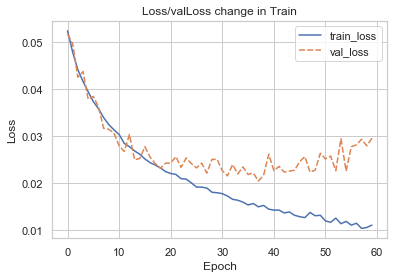

In [99]:
import re
pattern=r"loss: \d+.\d+"
pattern2=r"val_loss: \d+.\d+"
pat = re.compile(pattern)
pat2 =  re.compile(pattern2)
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
lossList = []
lossValList = []
with open("notes.txt","r") as f:
    for i,line in enumerate(f.readlines()):
        if i%4==1:
            res = pat.search(line)
            res2 = pat2.search(line)
            fdata = float(res.group(0).split(":")[1])
            fdata2 = float(res2.group(0).split(":")[1])
#             print(line)
            lossList.append(fdata)
            lossValList.append(fdata2)
data = pd.DataFrame({"train_loss":lossList,"val_loss":lossValList})
plt.figure()
sns.set(style="whitegrid")
plt.title("Loss/valLoss change in Train")
plt.ylabel("Loss")
plt.xlabel("Epoch")
sns.lineplot(data=data)
plt.savefig("loss.png",dpi=800)

In [97]:
import seaborn as sns
drawX = X
drawXduration = list(map(lambda x:x.shape[0]/config.sampling_rate,drawX))
sortedX = sorted(drawXduration)

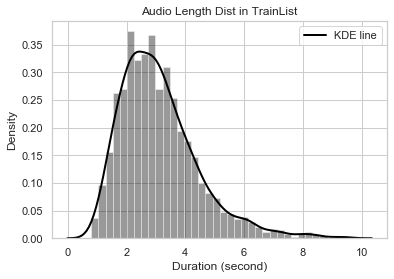

In [98]:
import matplotlib.pyplot as plt
plt.figure()
sns.set(style="whitegrid")
sns.distplot(sortedX,kde_kws={"color": "black", "lw": 2, "label": "KDE line"},color="black")
plt.title("Audio Length Dist in TrainList")
plt.ylabel("Density")
plt.xlabel("Duration (second)")
plt.savefig("dist.png",dpi=800)